In [196]:

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from xgboost import XGBRegressor 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [197]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])
print(data.shape)
data = data.drop(columns=['iso_code'])
data = data.set_index('date')
main = ['continent', 'tests_units', 'season', 'location']
data = pd.get_dummies(data, columns=main)

# Sort the DataFrame by the 'date' column
data = data.sort_index()
train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)

(2023, 53)
(1618, 67) (405, 67)


In [198]:

x_train = train.drop(columns=['new_deaths']) 
x_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']

In [199]:
metrics_df = pd.DataFrame(columns=['Model','mae','mase'])
metrics_df

,Model,mae,mase


In [200]:
data.dtypes

total_cases                float64
new_cases                  float64
new_deaths                 float64
total_cases_per_million    float64
new_cases_per_million      float64
                            ...   
location_Ireland              bool
location_Israel               bool
location_Italy                bool
location_Malaysia             bool
location_United States        bool
Length: 67, dtype: object

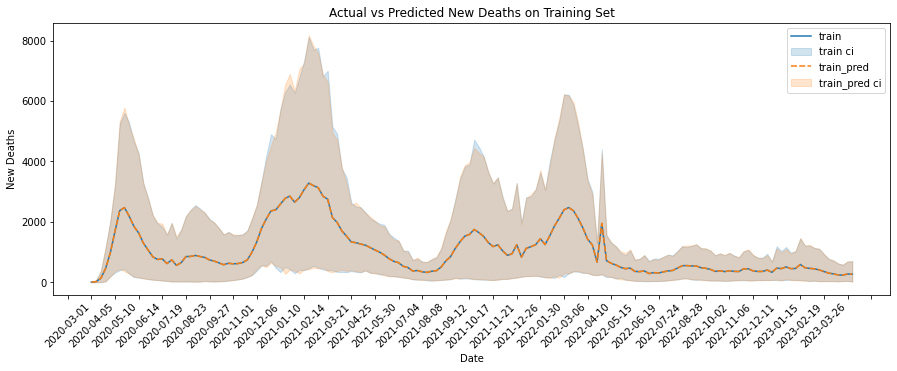

In [201]:
# Create XGBoost model
import matplotlib.ticker as ticker
model = xgb.XGBRegressor()

model.fit(x_train, y_train)

# Predict on the training set
train_pred = pd.DataFrame(model.predict(x_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train ci','train_pred','train_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

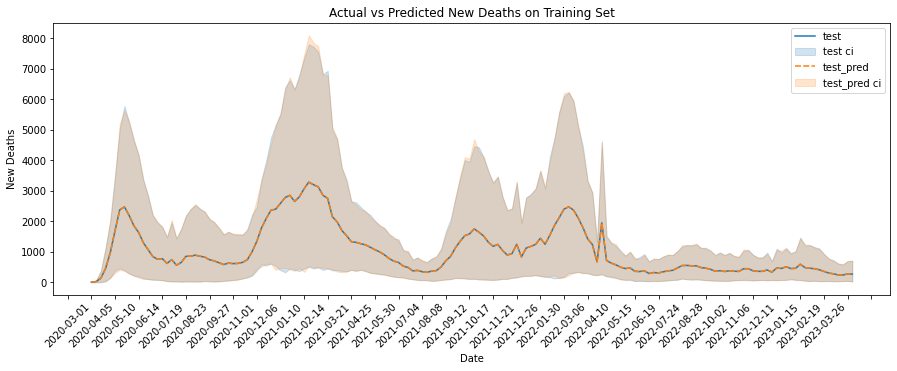

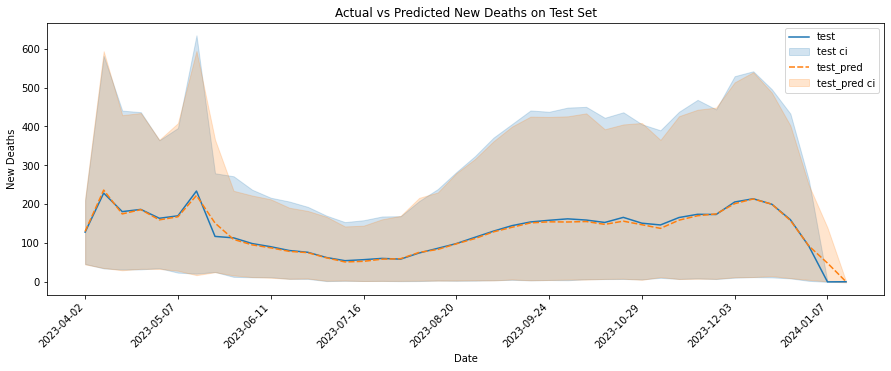

In [202]:
train_pred = pd.DataFrame(model.predict(x_train), columns=['yhat'], index=train.index)

# Plot the actual vs predicted values for training set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['test', 'test ci','test_pred','test_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

# Predict on the test set
test_pred = pd.DataFrame(model.predict(x_test), columns=['yhat'], index=test.index)

# Plot the actual vs predicted values for test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], test_pred['yhat']], axis=1))
plt.legend(['test', 'test ci','test_pred','test_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

In [203]:
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.array(y_true[:-1])
    y_true_insample = np.array(y_true[1:])
    insample_error = np.abs(y_true_insample - naive_forecast)
    # Calculate the forecast errors
    forecast_error = np.abs(y_true - y_pred)
    # Calculate the MASE
    mase = np.mean(forecast_error) / np.mean(insample_error)
    return mase

In [204]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['base xgb',mae, mase]

In [205]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464


In [206]:
import optuna
import sklearn.datasets
import sklearn.metrics

In [207]:


def objective(trial):

    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
   
    }

    bst = xgb.train(param, xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths']))
    preds = bst.predict(xgb.DMatrix(train.drop('new_deaths', axis=1)))
    
    accuracy = sklearn.metrics.mean_absolute_error(train['new_deaths'], preds)
    return accuracy

study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute  Error
study.optimize(objective, n_trials=10)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-03-12 13:39:23,699] A new study created in memory with name: no-name-f2b2ac0c-e6f7-4b22-b279-4ddcd5962eba


[I 2024-03-12 13:39:23,842] Trial 0 finished with value: 35.29691106633586 and parameters: {'n_estimators': 154, 'learning_rate': 0.30881500745090956, 'max_depth': 7}. Best is trial 0 with value: 35.29691106633586.
[I 2024-03-12 13:39:23,920] Trial 1 finished with value: 45.35648653032753 and parameters: {'n_estimators': 261, 'learning_rate': 0.2965413254015625, 'max_depth': 5}. Best is trial 0 with value: 35.29691106633586.


[13:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-12 13:39:24,027] Trial 2 finished with value: 240.04674672859414 and parameters: {'n_estimators': 178, 'learning_rate': 0.14178949873282673, 'max_depth': 9}. Best is trial 0 with value: 35.29691106633586.
[I 2024-03-12 13:39:24,117] Trial 3 finished with value: 70.38933889698629 and parameters: {'n_estimators': 51, 'learning_rate': 0.2482447336196395, 'max_depth': 10}. Best is trial 0 with value: 35.29691106633586.
[I 2024-03-12 13:39:24,184] Trial 4 finished with value: 28.13944694344576 and parameters: {'n_estimators': 117, 'learning_rate': 0.4040796339951283, 'max_depth': 5}. Best is trial 4 with value: 28.13944694344576.


[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-12 13:39:24,259] Trial 5 finished with value: 339.7308831665808 and parameters: {'n_estimators': 170, 'learning_rate': 0.1099083428544967, 'max_depth': 6}. Best is trial 4 with value: 28.13944694344576.
[I 2024-03-12 13:39:24,324] Trial 6 finished with value: 155.8627697575667 and parameters: {'n_estimators': 253, 'learning_rate': 0.18751431882131975, 'max_depth': 4}. Best is trial 4 with value: 28.13944694344576.
[I 2024-03-12 13:39:24,413] Trial 7 finished with value: 278.1502585136993 and parameters: {'n_estimators': 294, 'learning_rate': 0.12819314037056118, 'max_depth': 9}. Best is trial 4 with value: 28.13944694344576.


[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2024-03-12 13:39:24,518] Trial 8 finished with value: 40.415225939049265 and parameters: {'n_estimators': 198, 'learning_rate': 0.2951570605428152, 'max_depth': 8}. Best is trial 4 with value: 28.13944694344576.
[I 2024-03-12 13:39:24,643] Trial 9 finished with value: 328.4762047622053 and parameters: {'n_estimators': 171, 'learning_rate': 0.11290148174154428, 'max_depth': 7}. Best is trial 4 with value: 28.13944694344576.


[13:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694945373/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Best Params: {'n_estimators': 117, 'learning_rate': 0.4040796339951283, 'max_depth': 5}


In [208]:
model = xgb.XGBRegressor(n_estimators = 81, learning_rate = 0.41991808557315696, max_depth = 6)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

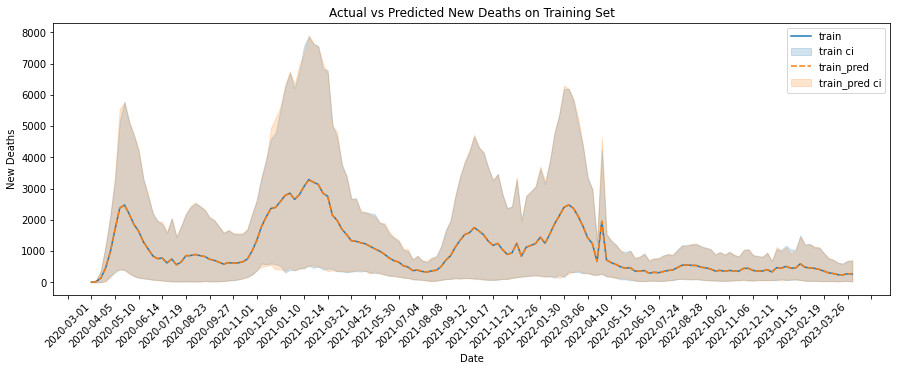

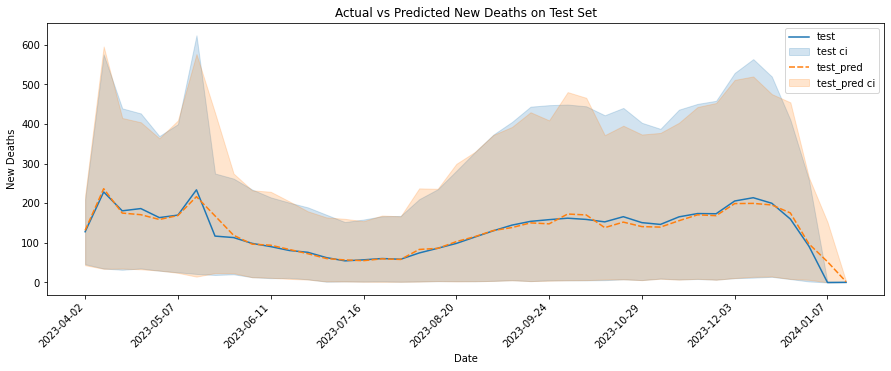

In [209]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['train', 'train ci','train_pred','train_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

# Predict on the test set
test_pred = pd.DataFrame(model.predict(x_test), columns=['yhat'], index=test.index)

# Plot the actual vs predicted values for test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], test_pred['yhat']], axis=1))
plt.legend(['test', 'test ci','test_pred','test_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

In [210]:
test_pred

,yhat
date,
2023-04-02,219.560196
2023-04-02,43.514023
2023-04-09,50.611778
2023-04-09,162.941666
2023-04-09,194.365570
...,...
2024-01-07,0.390391
2024-01-07,498.154297
2024-01-14,1.131484


In [211]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb',mae, mase]

In [212]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.527480,0.044047


In [213]:
import optuna
import xgboost as xgb
import sklearn.metrics

def objective(trial):
    param = {
        'objective': 'reg:squarederror',  # Assuming it's a regression task
        'eval_metric': 'mae',  # Using Mean Absolute Error as the evaluation metric
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    dtrain = xgb.DMatrix(train.drop('new_deaths', axis=1), label=train['new_deaths'])
    dval = xgb.DMatrix(test.drop('new_deaths', axis=1), label=test['new_deaths'])

    bst = xgb.train(param, dtrain, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=False)
    preds = bst.predict(dval, ntree_limit=bst.best_ntree_limit)

    accuracy = sklearn.metrics.mean_absolute_error(test['new_deaths'], preds)
    return accuracy

study = optuna.create_study(direction='minimize')  # Use 'minimize' for Mean Absolute Error
study.optimize(objective, n_trials=50)

# Access the best parameters
best_params = study.best_params
print("Best Params:", best_params)


[I 2024-03-12 13:39:34,966] A new study created in memory with name: no-name-f9c336bb-ce5c-4275-9b26-35127ad4817b
[I 2024-03-12 13:39:35,064] Trial 0 finished with value: 109.6279094013167 and parameters: {'learning_rate': 0.019716756355904013, 'max_depth': 5, 'subsample': 0.6326232436464236, 'colsample_bytree': 0.8525275731520721, 'min_child_weight': 5, 'gamma': 5.918931761057185e-05, 'reg_alpha': 0.00014813806533272366, 'reg_lambda': 0.0006105295248492597}. Best is trial 0 with value: 109.6279094013167.
[I 2024-03-12 13:39:35,287] Trial 1 finished with value: 45.94100289021009 and parameters: {'learning_rate': 0.12166069720859382, 'max_depth': 11, 'subsample': 0.8848562931474002, 'colsample_bytree': 0.9867687434490822, 'min_child_weight': 4, 'gamma': 0.2532443909813005, 'reg_alpha': 6.928320972321813e-05, 'reg_lambda': 0.13489256189698545}. Best is trial 1 with value: 45.94100289021009.
[I 2024-03-12 13:39:35,537] Trial 2 finished with value: 50.7534203003954 and parameters: {'learni

Best Params: {'learning_rate': 0.3587078966201627, 'max_depth': 11, 'subsample': 0.8389915388204895, 'colsample_bytree': 0.575773108517754, 'min_child_weight': 8, 'gamma': 5.374850829688839e-05, 'reg_alpha': 0.3366934092150998, 'reg_lambda': 0.000253401746841727}


In [214]:
model = xgb.XGBRegressor(learning_rate = 0.3457203617733065, max_depth = 9, subsample = 0.7239235547634495, colsample_bytree =0.8293582143467186,
                         min_child_weight= 7, gamma =  4.647743456869893e-05, reg_alpha = 4.391486737408028e-05, reg_lambda= 0.003061481940500537)
model.fit(train.drop('new_deaths', axis=1), train['new_deaths']);

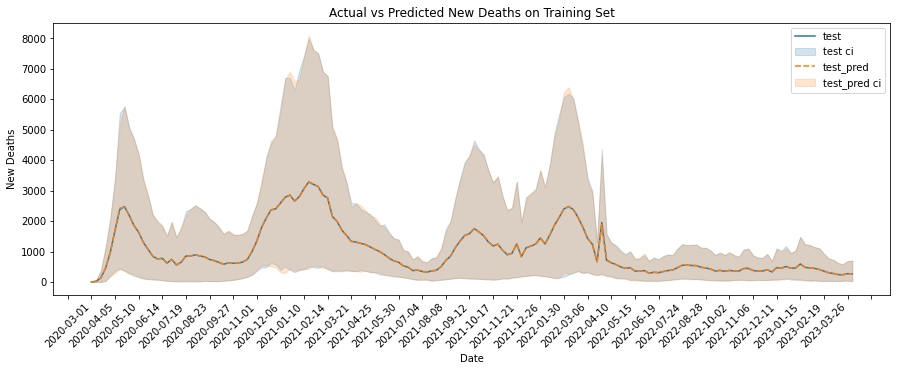

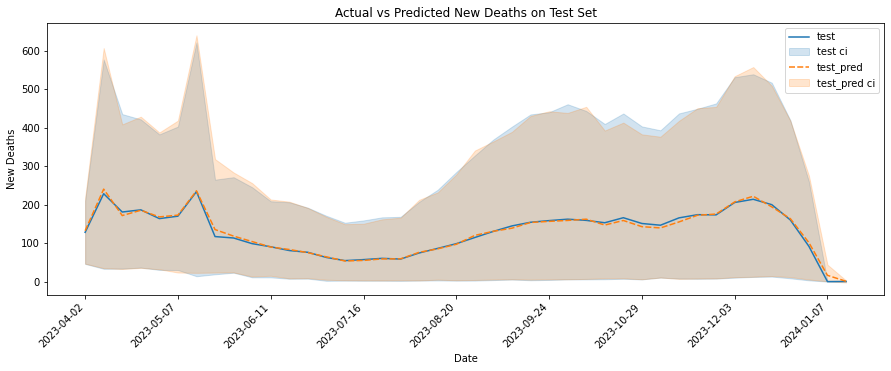

In [215]:
train_pred=pd.DataFrame(model.predict(train.drop('new_deaths', axis=1)), columns=['yhat'], index=train.index)
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([train['new_deaths'], train_pred['yhat']], axis=1))
plt.legend(['test', 'test ci','test_pred','test_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Training Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

# Predict on the test set
test_pred = pd.DataFrame(model.predict(x_test), columns=['yhat'], index=test.index)

# Plot the actual vs predicted values for test set
plt.figure(figsize=(15, 5))
sns.lineplot(data=pd.concat([test['new_deaths'], test_pred['yhat']], axis=1))
plt.legend(['test', 'test ci','test_pred','test_pred ci'])
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Actual vs Predicted New Deaths on Test Set')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha="right")
plt.show()

In [216]:
actuals = test['new_deaths'] 
predictions = test_pred['yhat'] 
mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb last try ',mae, mase]

In [217]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.527480,0.044047
2,optuna xgb last try,6.119393,0.025603


In [218]:
actuals = test['new_deaths'] 
predictions =  np.maximum(test_pred['yhat'] , 0)

mase = mean_absolute_scaled_error(actuals, predictions) 
mae = mean_absolute_error(actuals, predictions)

metrics_df.loc[len(metrics_df)] = ['optuna xgb last try',mae, mase]

In [219]:
metrics_df

,Model,mae,mase
0,base xgb,7.759172,0.032464
1,optuna xgb,10.527480,0.044047
2,optuna xgb last try,6.119393,0.025603
3,optuna xgb last try,6.066115,0.025380
